## Task 1: Extract Insights from Data

In [93]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [167]:
data_name = Path('Oppositional_thinking_analysis_dataset')
data_path = Path('data_ota') / data_name.with_suffix(".json")
assert data_path.exists, "File doesn't exist!"

In [168]:
# read file
with open(data_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.json_normalize(data)
display(df.head())

,id,text,category,annotations,spacy_tokens
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...


In [169]:
# Calculate text length
df['text_length'] = df['text'].apply(len)
# Calculate number of unique words
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
display(df.head())

,id,text,category,annotations,spacy_tokens,text_length,unique_words
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105


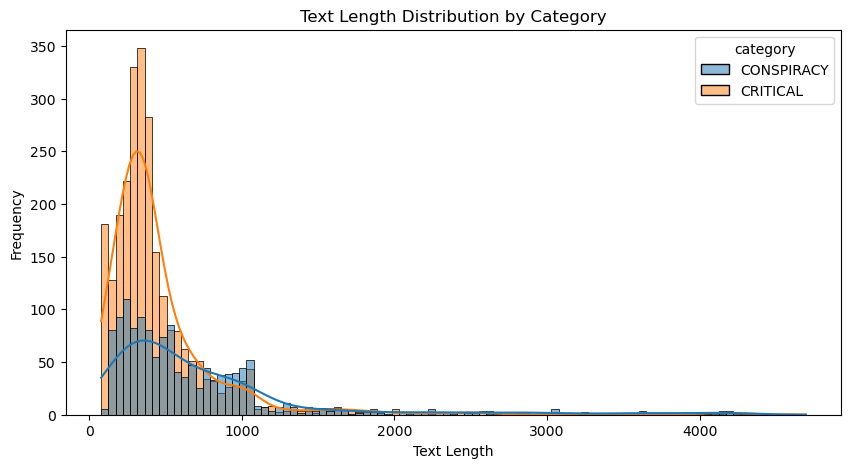

In [11]:
# Plot text length distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='text_length', hue='category', kde=True)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

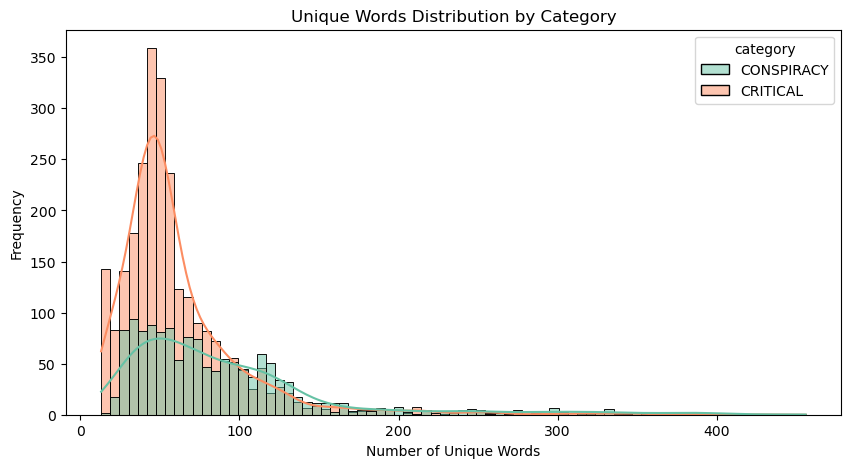

In [13]:
# Plot unique words distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='unique_words', hue='category', kde=True, palette='Set2')
plt.title('Unique Words Distribution by Category')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

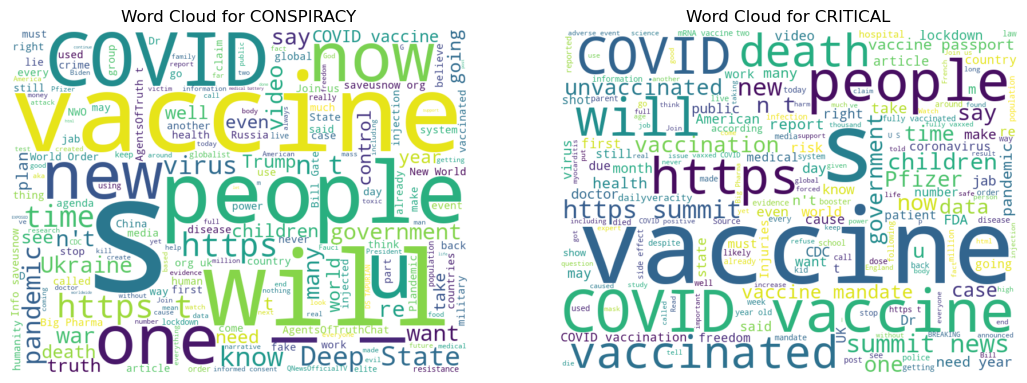

In [41]:
# Word Cloud for each category
plt.figure(figsize=(13, 8))
for category, i in zip(df['category'].unique(), range(2)):
    text = " ".join(df[df['category'] == category]['text'])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
plt.show()

In [170]:
# extract information of annotations and tokens
annotations_expanded = df.explode('annotations')[['id', 'annotations']]
annotations_df = pd.json_normalize(annotations_expanded['annotations'])
annotations_df['id'] = annotations_expanded['id'].values
annotations_df.head()

,span_text,category,annotator,start_char,end_char,start_spacy_token,end_spacy_token,id
0,Australian Senator Malcolm Roberts,CAMPAIGNER,gold_label,16,50,3,7,5206
1,the first politician,CAMPAIGNER,gold_label,135,155,24,27,5206
2,I ’m deeply concerned that the push to vaccina...,NEGATIVE_EFFECT,gold_label,2,135,1,22,1387
3,to vaccinate these children,OBJECTIVE,gold_label,38,65,8,12,1387
4,these children,VICTIM,gold_label,51,65,10,12,1387


In [171]:
# 统计每个category的出现次数
category_counts = annotations_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
print(category_counts)

          category  count
0       CAMPAIGNER   5096
1            AGENT   5082
2  NEGATIVE_EFFECT   4387
3           VICTIM   3517
4      FACILITATOR   2763
5        OBJECTIVE   1602
6                X    206


In [172]:
# 合并标注信息到原始数据
df = df.merge(annotations_df.groupby('id')['category'].apply(list).reset_index(), on='id', how='left', suffixes=('', '_annotations'))

# 显示合并后的数据样本
print(df[['id', 'text', 'category', 'category_annotations']].head())

      id                                               text    category  \
0   5206  THIS IS MASSIVE Australian Senator Malcolm Rob...  CONSPIRACY   
1   1387  “ I ’m deeply concerned that the push to vacci...    CRITICAL   
2  13116  2021 : They wanted to know your vaccination st...    CRITICAL   
3  11439  Anthony Fauci once again defended brutal Chine...    CRITICAL   
4     98  Proof has emerged showing that death from Wuha...    CRITICAL   

                                category_annotations  
0                           [CAMPAIGNER, CAMPAIGNER]  
1  [NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE...  
2                          [VICTIM, NEGATIVE_EFFECT]  
3          [NEGATIVE_EFFECT, AGENT, NEGATIVE_EFFECT]  
4  [NEGATIVE_EFFECT, CAMPAIGNER, NEGATIVE_EFFECT,...  


## Task 2: Pre-processing

In [173]:
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import time
import base64

In [161]:
def download_with_progress(resource):
    print(f"Downloading {resource}...")
    for _ in tqdm(range(100), desc=f"Downloading {resource}", unit="B", unit_scale=True, ncols=100):
        time.sleep(0.01)
    nltk.download(resource)

download_with_progress('punkt')
download_with_progress('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer() # initialize nltk stemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siyux\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siyux\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
def decode_tokens(tokens):
    """
    decode spaCy tokens from base64
    """
    decoded_bytes = base64.b64decode(tokens)
    decoded_str = decoded_bytes.decode('utf-8')
    return json.loads(decoded_str)

def preprocess_stpw(tokens):
    """
    normalization: remove punctuation and stop words
    """
    tokens = [token.lower() for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

def preprocess_stpw_stem(tokens):
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

In [187]:
# 解码和预处理 spacy tokens
df['decoded_tokens'] = df['spacy_tokens'].apply(decode_base64)
df['process_stpw_stem'] = df['decoded_tokens'].apply(preprocess_stpw_stem)
df['process_stpw'] = df['decoded_tokens'].apply(preprocess_stpw)

In [194]:
df.head()

,id,text,category,annotations,spacy_tokens,text_length,unique_words,category_annotations,decoded_tokens,process_stpw_stem,process_stpw,process_stem
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37,"[CAMPAIGNER, CAMPAIGNER]","[THIS, IS, MASSIVE, Australian, Senator, Malco...",thi is massiv australian senat malcolm robert ...,this is massive australian senator malcolm rob...,thi is massiv australian senat malcolm robert ...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48,"[NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE...","[“, I, ’m, deeply, concerned, that, the, push,...",i deepli concern push vaccin children noth dys...,i deeply concerned push vaccinate children not...,“ i ’m deepli concern that the push to vaccin ...
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28,"[VICTIM, NEGATIVE_EFFECT]","[2021, :, They, wanted, to, know, your, vaccin...",2021 they want know vaccin statu see paper all...,2021 they wanted know vaccination status see p...,2021 : they want to know your vaccin statu and...
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47,"[NEGATIVE_EFFECT, AGENT, NEGATIVE_EFFECT]","[Anthony, Fauci, once, again, defended, brutal...",anthoni fauci defend brutal chines lockdown ad...,anthony fauci defended brutal chinese lockdown...,anthoni fauci onc again defend brutal chines l...
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105,"[NEGATIVE_EFFECT, CAMPAIGNER, NEGATIVE_EFFECT,...","[Proof, has, emerged, showing, that, death, fr...",proof emerg show death wuhan coronaviru covid ...,proof emerged showing death wuhan coronavirus ...,proof ha emerg show that death from wuhan coro...


## Task 3: Text classification

In [151]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack

### Sub-task 1
* Split data into train and test sets. Use 20% of the data as the test set. Make sure to under or
over-sample in case of imbalance in classes.
* Train a naïve Bayes model on the training part and test it, using the test set.
    * Compare the impact of different vectorization models (e.g., count vectorizer, TF-IDF,
    and …) on the final performance of your naïve Bayes model.
    * Compare the impact of different pre-processing pipelines (e.g., with and without stop
    words, stemming, and …) on the final performance of your naïve Bayes model.
    * Perform error analysis on the model’s prediction. In other words, analyze errors that
    have been made by the model and describe why your model couldn’t work well in
    case of these errors.
* Train a feed-forward neural network model and report its performance (F1 score) on test data.
    * Again, compare the impact of different vectorization approaches on the final
    performance of your model.
    * Again, Compare the impact of different pre-processing pipelines (e.g., with and
    without stop words, stemming, and …) on the final performance of your model.
    * Perform error analysis on the model’s prediction.
* Compare the performance of your naïve Bayes model with the achieved results from the feed-
forward model. What can you conclude from the differences between the performance of the
two models?

In [263]:
class ModelComparision:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.y_pred = None, None, None, None, None

    def set_X(self, X):
        self.X = X
        
    def set_vectorizer(self, vectorizer):
        """
        Vectorize the text or text&annotations into feature vectors.
        """
        if vectorizer == 'bow':
            return CountVectorizer()
        elif vectorizer == 'tfidf':
            return TfidfVectorizer()
        
    def set_model(self, model):
        if model == 'nb':
            return MultinomialNB()
        else:
            return True


    def predict(self, vectorizer='bow', model='nb'):
        V = self.set_vectorizer(vectorizer)
        X_vectorized = V.fit_transform(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_vectorized, self.y, test_size=0.2, random_state=42)
        M =  self.set_model(model)
        
        M.fit(self.X_train, self.y_train)
        self.y_pred = M.predict(self.X_test)

        self.evaluation()

    def evaluation(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        confusion = confusion_matrix(self.y_test, self.y_pred)

        report_df = pd.DataFrame(report).transpose().iloc[:2]
        confusion = confusion[:2, :2]

        # 美观地打印结果
        print(f"Accuracy: {accuracy:.4f}\n")
        print("Classification Report:\n", report_df)

        plt.figure(figsize=(6, 3.5))
        plt.subplot(1,2,1)
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
        plt.title('clf')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        report_df.drop(['support'], axis=1, inplace=True)
        report_df.plot(kind='bar', ax=plt.gca())
        plt.title('clf')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.legend(loc='lower right')
        
        plt.tight_layout()
        plt.show()

In [264]:
MC = ModelComparision(df['process_stpw'], df['category'])

Accuracy: 0.8612

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.770115  0.797619  0.783626    252.0
CRITICAL     0.905380  0.890511  0.897884    548.0


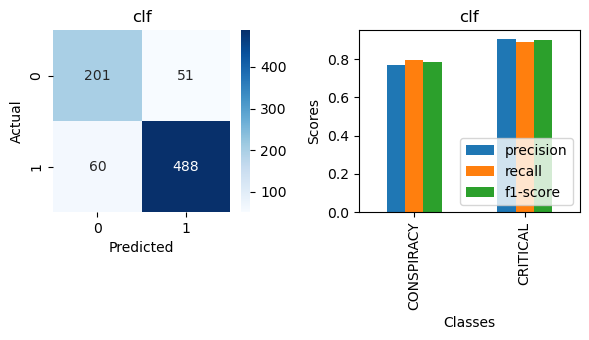

In [265]:
MC.predict()

Accuracy: 0.8187

Classification Report:
             precision   recall  f1-score  support
CONSPIRACY   0.981982  0.43254  0.600551    252.0
CRITICAL     0.792453  0.99635  0.882781    548.0


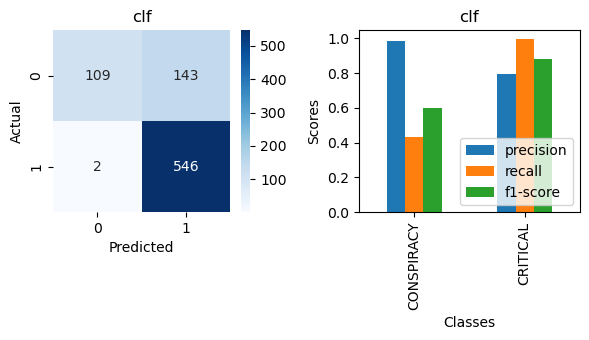

In [266]:
MC.predict('tfidf', 'nb')

Accuracy: 0.8638

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.773946  0.801587  0.787524    252.0
CRITICAL     0.907236  0.892336  0.899724    548.0


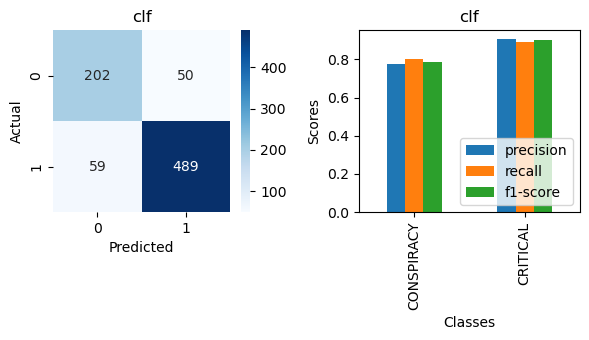

In [268]:
MC.set_X(df['process_stpw_stem'])
MC.predict('bow', 'nb')

Accuracy: 0.8275

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.959677  0.472222  0.632979    252.0
CRITICAL     0.803254  0.990876  0.887255    548.0


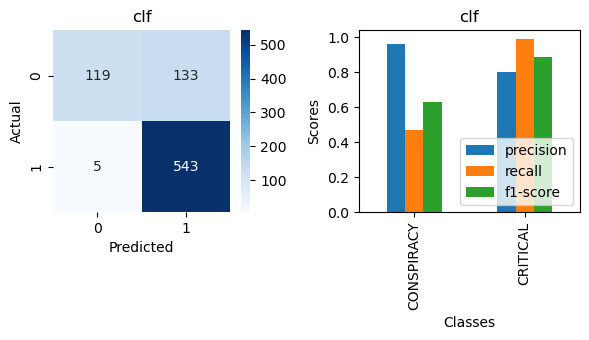

In [269]:
MC.predict('tfidf', 'nb')